In [1]:
import os
import glob
from tqdm.auto import tqdm
import pickle
import re
import networkx as nx
import csv
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pandas as pd
%matplotlib inline
import statsmodels.nonparametric

In [2]:
with  open("ground_truth_cancer.pkl", "rb") as f:
    ground_truths = pickle.load(f)

def calculate_f_score(genes1,genes2):
    f_score = 0
    set1 = set(genes1)
    set2 = set(genes2)
    # Calculate true positives (TP)
    true_positives = len(set1.intersection(set2))
    # Calculate false positives (FP) and false negatives (FN)
    false_positives = len(set2.difference(set1))
    false_negatives = len(set1.difference(set2))
    # Calculate precision and recall
    if true_positives + false_positives == 0:
        precision = 1
    else:
        precision = true_positives / (true_positives + false_positives)

    if true_positives + false_negatives == 0:
        recall = 1
    else:
        recall = true_positives / (true_positives + false_negatives)

    # Calculate F-score
    if precision + recall == 0:
        f_score = 0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)

    return f_score

def calculate_fsub_score(subnetworks,ground_truths):
    fsub_score = 0
    f_scores = []

    for ground_truth in ground_truths:
        max_f_score = 0
        for subnetwork in subnetworks:
            f_score = calculate_f_score(subnetwork, ground_truth)
            max_f_score = max(max_f_score, f_score)

        weighted_f_score = max_f_score * len(ground_truth)
        f_scores.append(weighted_f_score)

    fsub_score = sum(f_scores) / sum([len(g) for g in ground_truths])
    return fsub_score

def load_graph_structure(edge_list_file):
    with open(edge_list_file, "r") as f:
        lines = f.readlines()[1:] # Skip the first row
    graph = nx.parse_edgelist(lines, delimiter='\t', nodetype=str, data=(('weight', float),))
    return graph

network_files = {
    'biogrid': '/Users/leyang/Dropbox/Projects/Subnetwork_survey/code/networks/biogrid_edge_list.tsv',
    'irefindex18': '/Users/leyang/Dropbox/Projects/Subnetwork_survey/code/networks/irefindex18_edge_list.tsv',
    'reactome21': '/Users/leyang/Dropbox/Projects/Subnetwork_survey/code/networks/reactome21_edge_list.tsv',
    'string': '/Users/leyang/Dropbox/Projects/Subnetwork_survey/code/networks/string_edge_list.tsv',
}

network_object = {
    'biogrid': load_graph_structure(network_files['biogrid']),
    'irefindex18': load_graph_structure(network_files['irefindex18']),
    'reactome21': load_graph_structure(network_files['reactome21']),
    'string': load_graph_structure(network_files['string']),
}

In [3]:
# calculate f, fsub, flatten lfdr
with open('lfdr_real.pkl', 'rb') as f:
    df_for_plot = pickle.load(f)
df_v4 = df_for_plot[df_for_plot['data_version'].str.endswith('v4')]
#df_v4_mean = df_v4.groupby(['method','data_version']).mean()
performance = list(df_v4.itertuples(index=False, name=None))
p_plot_all = []
for method, data_version, network_name, subs, lfdr in performance:
    fsub_corum = calculate_fsub_score(subs,ground_truths['targets']['corum_cancer'])
    fscore_corum = calculate_f_score(set().union(*subs),set().union(*ground_truths['targets']['corum_cancer']))
    fsub_reactome = calculate_fsub_score(subs,ground_truths['targets']['reactome_cancer'])
    fscore_reactome = calculate_f_score(set().union(*subs),set().union(*ground_truths['targets']['reactome_cancer']))
    p_plot_all.append((method,data_version,network_name,fsub_corum,fscore_corum,fsub_reactome,fscore_reactome))
df_plot_all = pd.DataFrame(p_plot_all, columns=["method", "data_version", "network_name","Fsub-CORUM","F-CORUM","Fsub-Reactome","F-Reactome"])

p_plot_fdr = []
for method, data_version, network_name, subs, lfdr in performance:
    for i in range(len(subs)):
        p_plot_fdr.append((method,data_version,network_name,lfdr[i]))
        
df_plot_fdr = pd.DataFrame(p_plot_fdr, columns=["method", "data_version", "network_name","lfdr"])


with open("node_property.pkl", "rb") as f:
    node_property = pickle.load(f)
    
node_topo_result = []
for method, data_version, network_name, subs, lfdr in performance:
    if len(subs)>1:
        all_genes = set().union(*subs)
    for gene in all_genes:
        if network_object[network_name].has_node(gene):
            deg = network_object[network_name].degree[gene]
            bc = node_property['between'][network_name][gene]
            clc = node_property['cluster'][network_name][gene]
            ec = node_property['eigen'][network_name][gene]
            node_topo_result.append((method,data_version,network_name,deg,bc,clc,ec))
    
df_node_detection = pd.DataFrame(node_topo_result, columns=["method", "data_version","network_name" ,"degree","betweenness centrality" \
                                                                 ,"clustering coefficient","eigenvector_centrality"])


network_topo_result = []
for method, data_version, network_name, subs, lfdr in performance:
    for raw_sub in subs:
        g = network_object[network_name]
        node_in_graph = [x for x in raw_sub if g.has_node(x)]
        sub = g.subgraph(node_in_graph)
        ms = sub.size()
        cs = nx.cut_size(g,node_in_graph)
        if cs == 0:
            continue
        Separability = ms/cs
        Density = nx.density(sub)
        Conductance = nx.conductance(g,node_in_graph)
        Clustering = nx.average_clustering(g,node_in_graph)
        network_topo_result.append((method,data_version,network_name,Separability,Density,Conductance,Clustering))
    
df_network_detection = pd.DataFrame(network_topo_result, columns=["method", "data_version","network_name","Separability","Density","Conductance","Clustering"])




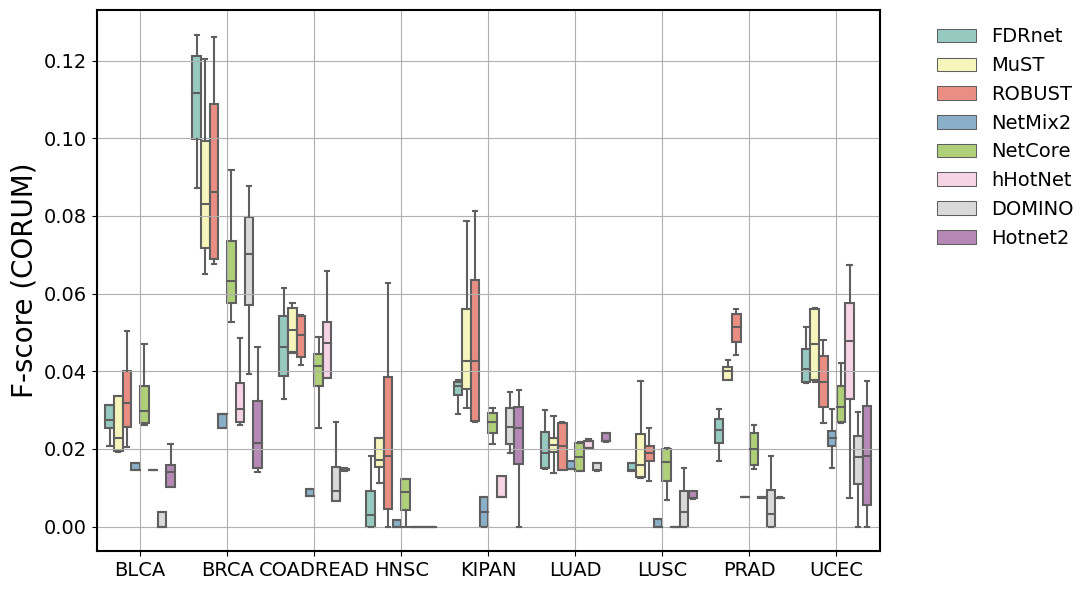

In [6]:
# plot F-CORUM
my_labels = ['FDRnet', 'MuST','ROBUST','NetMix2','NetCore','hHotNet',  'DOMINO', 'Hotnet2']
fig, ax = plt.subplots(figsize=(9,6))
label_size = 20
legend_size = 14
tick_size =14
my_hue = 'method'
my_palette = sns.color_palette("Set3",12)

#my_labels = ['FDRnet', 'MuST','BioNet', 'ROBUST','NetMix2','DIAMOnD','NetCore','hHotNet',  'DOMINO', 'Hotnet2',  'ClustEx','RegMOD']
cancers =  ['BLCA_MERGE','BRCA_MERGE','COADREAD_MERGE','HNSC_MERGE','KIPAN_MERGE','LUAD_MERGE','LUSC_MERGE','PRAD_MERGE','UCEC_MERGE']# Create the boxplot
cancers_name = ['BLCA','BRCA','COADREAD','HNSC','KIPAN','LUAD','LUSC','PRAD','UCEC']# Create the boxplot
my_hue_order = ['fdrnet', 'must','robust','netmix2','netcore','hhotnet', 'domino', 'hotnet2']
sns.boxplot(x='data_version', y='F-CORUM',hue=my_hue, hue_order = my_hue_order, data=df_plot_all, 
                ax=ax,palette = [my_palette[x] for x in range(len(my_palette)) if x in [0,1,3,4,6,7,8,9]],order=cancers,fliersize=0)
ax.set_xlabel('', fontsize=label_size)
ax.set_ylabel('F-score (CORUM)', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid(True)
ax.set_xticklabels(cancers_name)
# Optimize the layout
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')  # Set border color to black
plt.tight_layout()
L = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=legend_size,ncol=1,fancybox=True,frameon=False)
# for i in range(len(my_labels)):
#     L.get_texts()[i].set_text(my_labels[i])
for i in range(len(my_labels)):
    L.get_texts()[i].set_text(my_labels[i])
plt.savefig('../writing/raw_figures/real_f_corum.png',dpi=300,bbox_inches='tight')

In [26]:
[my_palette[x] for x in range(len(my_palette)) if x in [0,1,2,3]]

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118)]

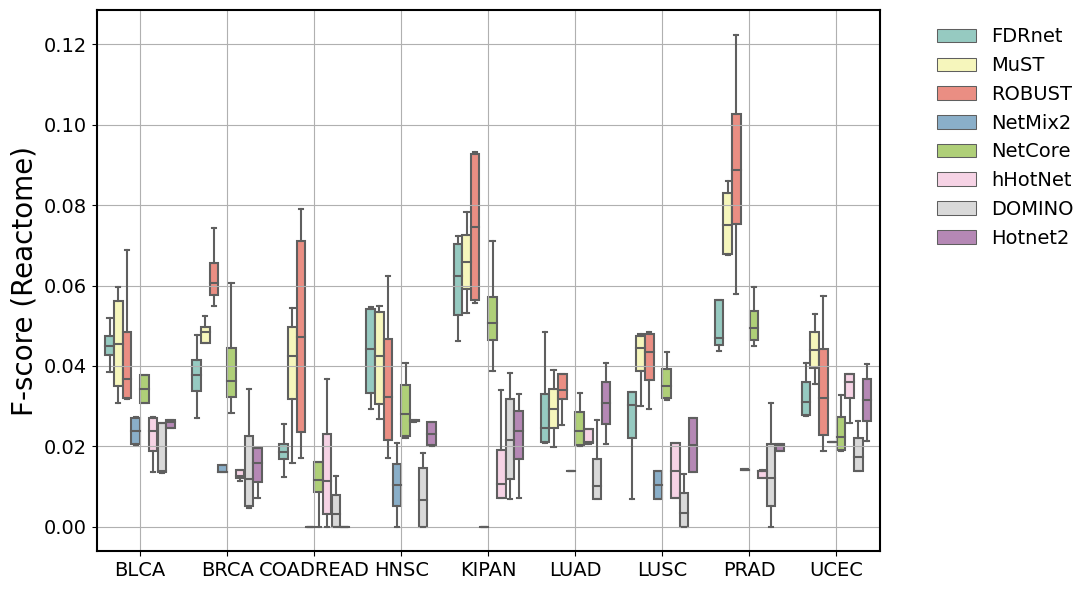

In [7]:
# plot F-Reactome
fig, ax = plt.subplots(figsize=(9,6))
label_size = 20
legend_size = 14
tick_size =14
my_hue = 'method'
my_palette = sns.color_palette("Set3",12)

#my_labels = ['FDRnet', 'MuST','BioNet', 'ROBUST','NetMix2','DIAMOnD','NetCore','hHotNet',  'DOMINO', 'Hotnet2',  'ClustEx','RegMOD']
cancers =  ['BLCA_MERGE','BRCA_MERGE','COADREAD_MERGE','HNSC_MERGE','KIPAN_MERGE','LUAD_MERGE','LUSC_MERGE','PRAD_MERGE','UCEC_MERGE']# Create the boxplot
cancers_name = ['BLCA','BRCA','COADREAD','HNSC','KIPAN','LUAD','LUSC','PRAD','UCEC']# Create the boxplot
#my_hue_order = ['fdrnet', 'must','bionet', 'robust','netmix2','diamond','netcore','hhotnet',  'domino', 'hotnet2', 'clustex','regmod']
sns.boxplot(x='data_version', y='F-Reactome',hue=my_hue, hue_order = my_hue_order, data=df_plot_all, 
                ax=ax,palette = [my_palette[x] for x in range(len(my_palette)) if x in [0,1,3,4,6,7,8,9]],order=cancers,fliersize=0)
ax.set_xlabel('', fontsize=label_size)
ax.set_ylabel('F-score (Reactome)', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid(True)
ax.set_xticklabels(cancers_name)
# Optimize the layout
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')  # Set border color to black
plt.tight_layout()
L = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=legend_size,ncol=1,fancybox=True,frameon=False)
# for i in range(len(my_labels)):
#     L.get_texts()[i].set_text(my_labels[i])
for i in range(len(my_labels)):
    L.get_texts()[i].set_text(my_labels[i])
plt.savefig('../writing/raw_figures/real_f_reactome.png',dpi=300,bbox_inches='tight')

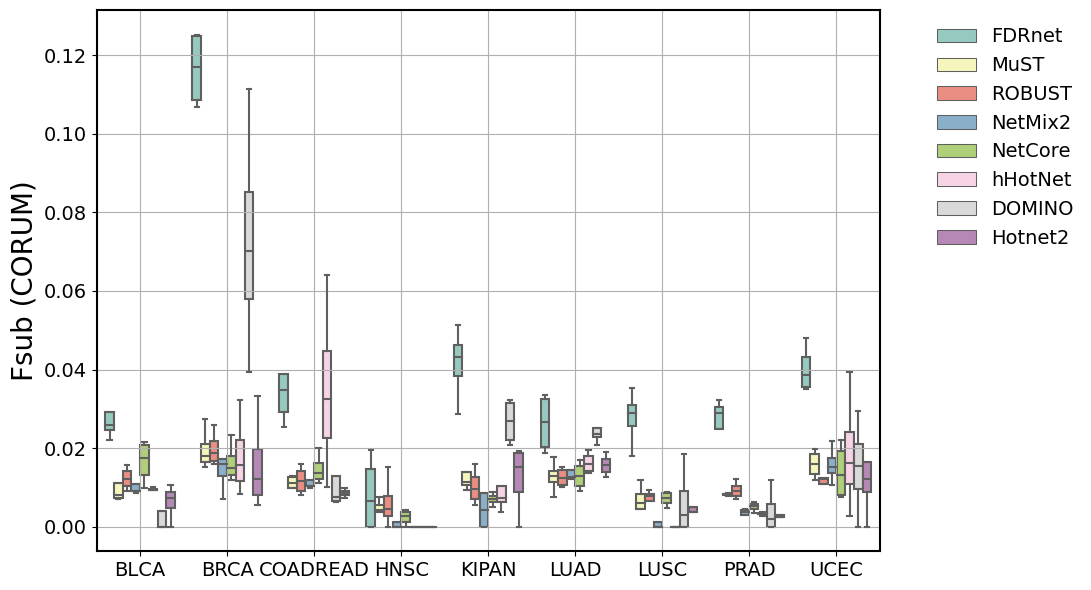

In [8]:
# plot Fsub-CORUM
fig, ax = plt.subplots(figsize=(9,6))
label_size = 20
legend_size = 14
tick_size =14
my_hue = 'method'
my_palette = sns.color_palette("Set3",12)

#my_labels = ['FDRnet', 'MuST','BioNet', 'ROBUST','NetMix2','DIAMOnD','NetCore','hHotNet',  'DOMINO', 'Hotnet2',  'ClustEx','RegMOD']
cancers =  ['BLCA_MERGE','BRCA_MERGE','COADREAD_MERGE','HNSC_MERGE','KIPAN_MERGE','LUAD_MERGE','LUSC_MERGE','PRAD_MERGE','UCEC_MERGE']# Create the boxplot
cancers_name = ['BLCA','BRCA','COADREAD','HNSC','KIPAN','LUAD','LUSC','PRAD','UCEC']# Create the boxplot
#my_hue_order = ['fdrnet', 'must','bionet', 'robust','netmix2','diamond','netcore','hhotnet',  'domino', 'hotnet2', 'clustex','regmod']
sns.boxplot(x='data_version', y='Fsub-CORUM',hue=my_hue, hue_order = my_hue_order, data=df_plot_all, 
                ax=ax,palette = [my_palette[x] for x in range(len(my_palette)) if x in [0,1,3,4,6,7,8,9]],order=cancers,fliersize=0)
ax.set_xlabel('', fontsize=label_size)
ax.set_ylabel('Fsub (CORUM)', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid(True)
ax.set_xticklabels(cancers_name)
# Optimize the layout
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')  # Set border color to black
plt.tight_layout()
L = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=legend_size,ncol=1,fancybox=True,frameon=False)
# for i in range(len(my_labels)):
#     L.get_texts()[i].set_text(my_labels[i])
for i in range(len(my_labels)):
    L.get_texts()[i].set_text(my_labels[i])
plt.savefig('../writing/raw_figures/real_fsub_corum.png',dpi=300,bbox_inches='tight')

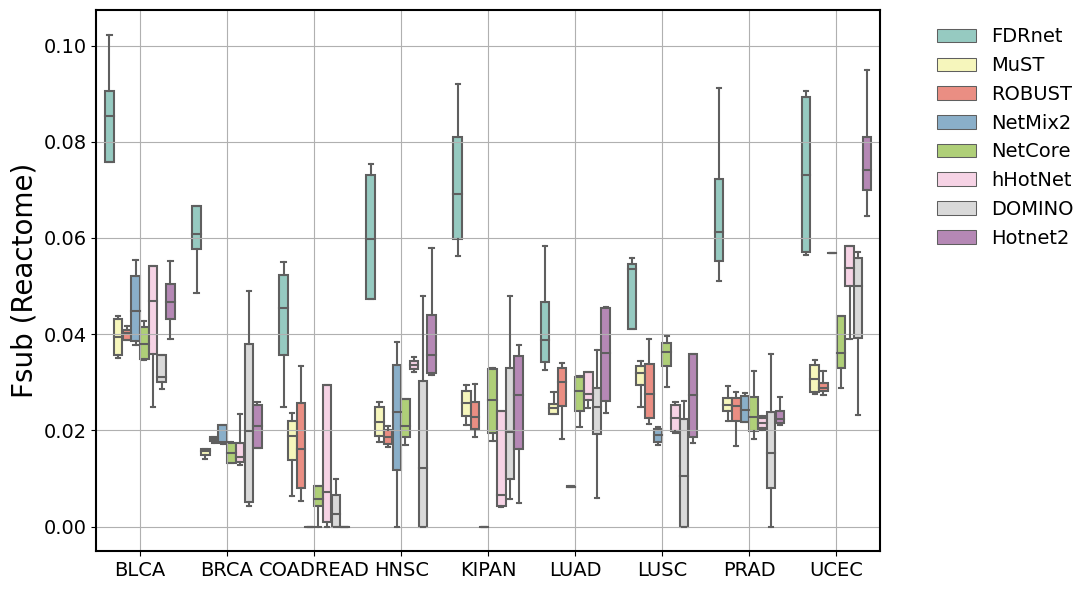

In [9]:
# plot Fsub-Reactome
fig, ax = plt.subplots(figsize=(9,6))
label_size = 20
legend_size = 14
tick_size =14
my_hue = 'method'
my_palette = sns.color_palette("Set3",12)

#my_labels = ['FDRnet', 'MuST','BioNet', 'ROBUST','NetMix2','DIAMOnD','NetCore','hHotNet',  'DOMINO', 'Hotnet2',  'ClustEx','RegMOD']
cancers =  ['BLCA_MERGE','BRCA_MERGE','COADREAD_MERGE','HNSC_MERGE','KIPAN_MERGE','LUAD_MERGE','LUSC_MERGE','PRAD_MERGE','UCEC_MERGE']# Create the boxplot
cancers_name = ['BLCA','BRCA','COADREAD','HNSC','KIPAN','LUAD','LUSC','PRAD','UCEC']# Create the boxplot
#my_hue_order = ['fdrnet', 'must','bionet', 'robust','netmix2','diamond','netcore','hhotnet',  'domino', 'hotnet2', 'clustex','regmod']
sns.boxplot(x='data_version', y='Fsub-Reactome',hue=my_hue, hue_order = my_hue_order, data=df_plot_all, 
                ax=ax,palette = [my_palette[x] for x in range(len(my_palette)) if x in [0,1,3,4,6,7,8,9]],order=cancers,fliersize=0)
ax.set_xlabel('', fontsize=label_size)
ax.set_ylabel('Fsub (Reactome)', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid(True)
ax.set_xticklabels(cancers_name)
# Optimize the layout
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')  # Set border color to black
plt.tight_layout()
L = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=legend_size,ncol=1,fancybox=True,frameon=False)
# for i in range(len(my_labels)):
#     L.get_texts()[i].set_text(my_labels[i])
for i in range(len(my_labels)):
    L.get_texts()[i].set_text(my_labels[i])
plt.savefig('../writing/raw_figures/real_fsub_reactome.png',dpi=300,bbox_inches='tight')

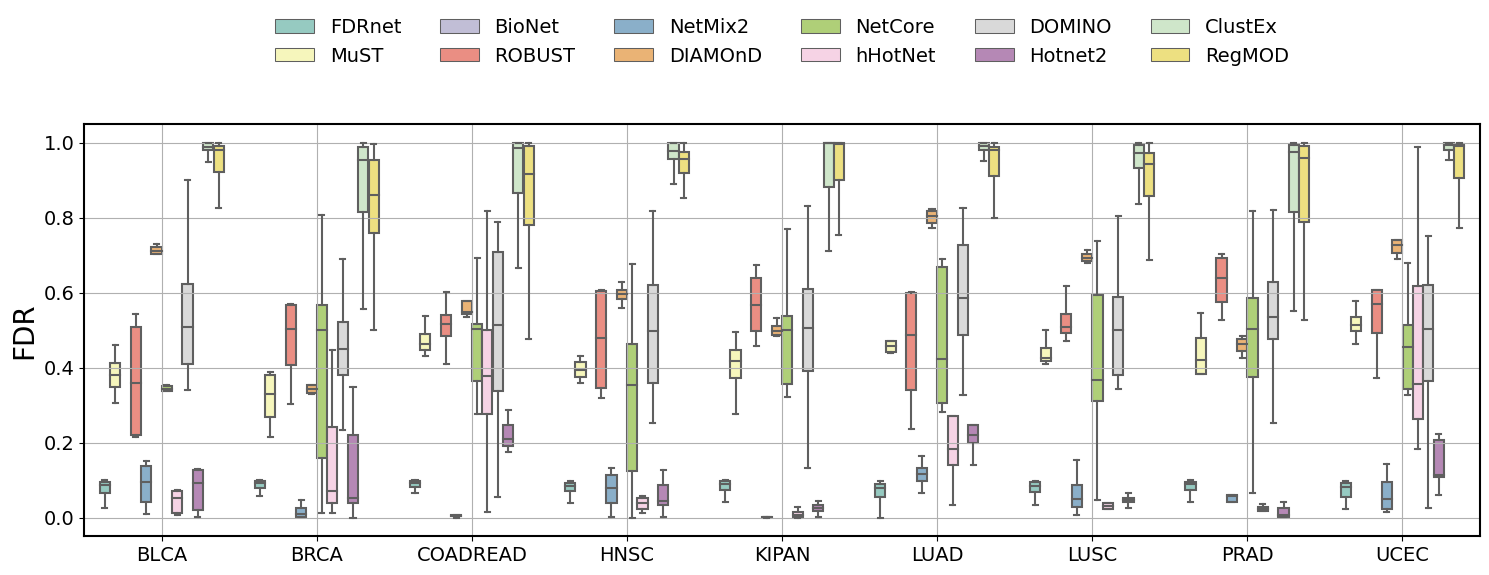

In [10]:
######################### plot FDR
# Adjust the figure size
fig, ax = plt.subplots(figsize=(15,6))
my_hue = 'method'
my_hue_order = ['fdrnet', 'must','bionet', 'robust','netmix2','diamond','netcore','hhotnet',  'domino', 'hotnet2', 'clustex','regmod']
my_labels = ['FDRnet', 'MuST','BioNet', 'ROBUST','NetMix2','DIAMOnD','NetCore','hHotNet',  'DOMINO', 'Hotnet2',  'ClustEx','RegMOD']
cancers =  ['BLCA_MERGE','BRCA_MERGE','COADREAD_MERGE','HNSC_MERGE','KIPAN_MERGE','LUAD_MERGE','LUSC_MERGE','PRAD_MERGE','UCEC_MERGE']# Create the boxplot
cancers_name = ['BLCA','BRCA','COADREAD','HNSC','KIPAN','LUAD','LUSC','PRAD','UCEC']# Create the boxplot
sns.boxplot(x='data_version', y='lfdr', hue=my_hue, hue_order = my_hue_order, data=df_plot_fdr, width=0.8, 
            fliersize=0,ax=ax,palette=my_palette,order=cancers)

# Set axis labels and title
ax.set_xlabel('', fontsize=label_size)
ax.set_ylabel('FDR', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid(True)
ax.set_yticks(ticks=[0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels(['BLCA','BRCA','COADREAD','HNSC','KIPAN','LUAD','LUSC','PRAD','UCEC'])

L = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), fontsize=legend_size,ncol=6,fancybox=True,frameon=False)
for i in range(len(my_labels)):
    L.get_texts()[i].set_text(my_labels[i])

# Optimize the layout
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')  # Set border color to black
plt.tight_layout()
plt.savefig('../writing/raw_figures/real_fdr.png',dpi=300)
